In [1]:
import matplotlib.pyplot as plt
import numpy as np
import sim
import util
import torch
from IPython.display import clear_output
from models import GibbsLDA, CollapsedGibbsLDA, PyroLDA
from pyro.distributions import Dirichlet, Categorical
from tqdm import tqdm

clear_output()

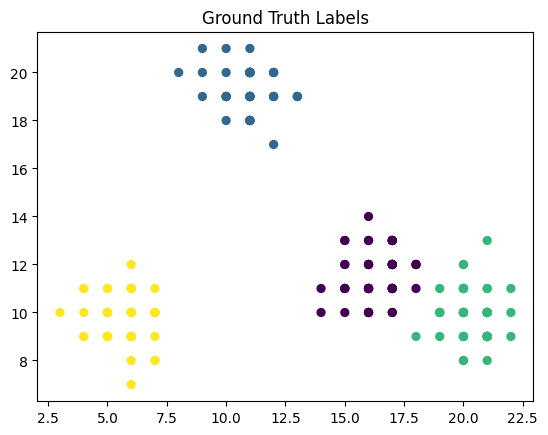

In [2]:
N_SAMPLES = 200
N_FEATURES = 100
N_TOPICS = 4
SCALE = 1
DISCRETIZE = True
SHUFFLE = True

if DISCRETIZE:
    X, X_labels, vocab = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
else:
    X, X_labels = sim.generate_data(N_SAMPLES, N_FEATURES, N_TOPICS, SCALE, DISCRETIZE, SHUFFLE)
util.visualize_data(X, X_labels, 'Ground Truth Labels')

100%|██████████| 200/200 [01:32<00:00,  2.16it/s]

Score: 0.935


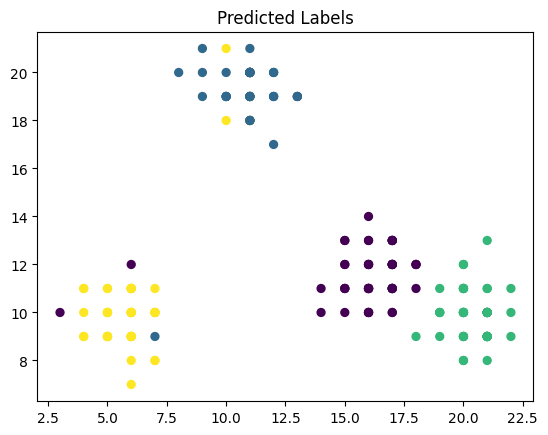

In [5]:
N_STEPS = 200

model = GibbsLDA(N_TOPICS).fit(X, N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

100%|██████████| 200/200 [01:38<00:00,  2.04it/s]

Score: 0.935


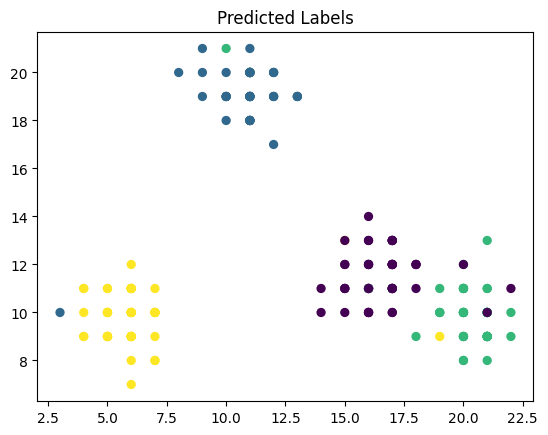

In [6]:
N_STEPS = 200

model = CollapsedGibbsLDA(N_TOPICS).fit(torch.tensor(X), N_STEPS)
Y_labels, score = util.evaluate(X_labels, model.transform(X))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

100%|██████████| 200/200 [00:01<00:00, 126.27it/s]


Score: 0.955


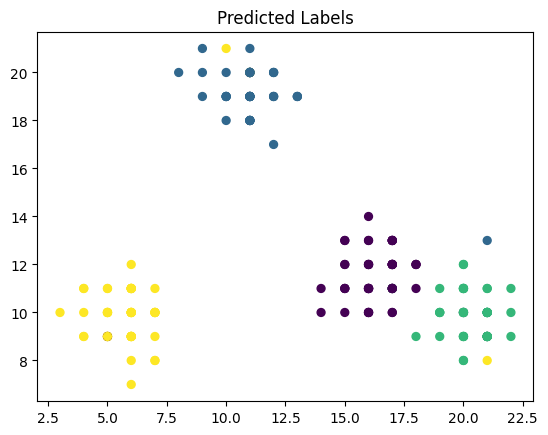

In [7]:
N_STEPS = 200

Y = torch.tensor(X).T
model = PyroLDA(N_TOPICS, batch_size=100).fit(Y, N_STEPS, 1e-1)
Y_labels, score = util.evaluate(X_labels, model.transform(Y))
print('Score:', score)
util.visualize_data(X, Y_labels, 'Predicted Labels')

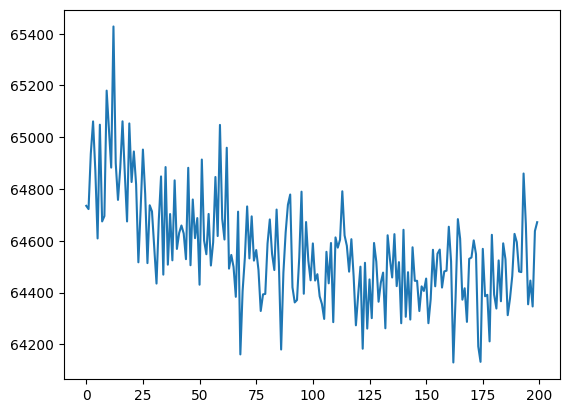

In [8]:
y = model.loss_log_
x = np.arange(len(y))
plt.plot(x, y);